In [1]:
# imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

import pandas as pd
import numpy as np

from utils.basic_utils import read_dates, load_csvs, csv_load, excl, csv_store
from utils.pricing import roll_vol, load_px_close, discret_rets, get_ind_index
from utils.fundamental import filter_cols, filter_cols
from scipy.stats import linregress

import matplotlib as mpl
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format

Loading utils/config.json


In [2]:
# utility functions
def top_recomm_by_class(pred_df, labels, top_items):
    mask = pred_df.hard_pred_label == pred_df.soft_pred_label
    agree_df = pred_df.loc[mask].drop_duplicates()
    # should add sector and industries, group for allocation insights
    # should add marketcap, beta, etc, group for risk exposure insights
    label_mask = agree_df.soft_pred_label.isin(['bear', 'short', 'long', 'bull'])
    return agree_df.loc[label_mask]\
        .sort_values(by='soft_confidence', ascending=False)\
        .groupby(by='soft_pred_label').head(top_items)\
        .sort_values(by='soft_pred_class')

def pred_distrib(pred_df, count_col):
    dist = pd.value_counts(pred_df[count_col]).to_frame()
    dist['weights'] = dist / dist.sum()
    return dist

def add_desc_stats(df, descriptive_cols):
    
    tickers = df.index
    for k in descriptive_cols.keys():
        desc_df, cols = descriptive_cols[k]['df'], descriptive_cols[k]['columns']
        for c in cols: df.loc[:, c] = tickers.map(desc_df[c].to_dict()).values 

    df = clean_df(df, large_vals, div_cols)

    df.loc[:, 'pegRatio'] = df.forwardPE / (val_df.growthRate * 100)
    df.loc[:, 'size'] = discret_rets(df.marketCap, mkt_cap_cuts, mkt_cap_labels)
        
    return df

def clean_df(df, large_vals, div_cols):
    # convert large values to billions
    df.loc[:, large_vals] = df.loc[:, large_vals] / 10**9
    df.loc[:, div_cols] = df[div_cols].div(df.regularMarketPrice, axis=0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return df

def ml_votes_by_class(fndm_dfs, group_mask):
    super_list = []
    for key in fndm_dfs.keys():
        df = fndm_dfs[key]
        super_list.append(
            fndm_dfs[key].loc[:, group_mask].set_index(re_index_col)\
            .rename(columns={group_mask[0]: key}))
    df = pd.concat(super_list, axis=1, sort=False)
    # df.apply(pd.value_counts).loc[fwd_ret_labels].style.background_gradient(cmap='RdYlGn')
    return df.T.apply(pd.value_counts).T

q_group = lambda x, q: x.quantile(q)

ticker_across_mls = lambda ticker, df: df.set_index('symbol').loc[ticker]

# equal weight ml_confidence
equal_wgt_conf = lambda x: ticker_across_mls(x[0]).loc[:, x[1]].mean()

# take index and class, and calculate a dot product, weighted confidence
score_wgt_conf = lambda x: ticker_across_mls(x[0], lf_df).loc[
    :, [x[1], 'model']].set_index('model').T.mul(model_weights).sum(1).iloc[0]

def load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols, verbose=True):
    """ Read ML prediction files """
    print(f'Loading files for {tgt_date}')
    fndm_dfs = {k: pd.read_csv(csv_load(f'{s3_path[k]}{tgt_date}'), 
            index_col='pred_date', parse_dates=True) for k in key_list}

    super_list = []
    for key in fndm_dfs.keys(): 
        fndm_dfs[key].loc[:, 'model'] = key
        fndm_dfs[key] = fndm_dfs[key].loc[fndm_dfs[key].symbol.isin(eqty_symbols), :]
        df = fndm_dfs[key]
        if verbose: print(f'{key.upper()}, {df.symbol.shape[0]} unique symbols')
        super_list.append(df)
        
    return pd.concat(super_list, axis=0)

def get_wtd_ML_results(lf_df, model_weights):
    """ calculate model weighted class and confidence level for ranking / sorting """
    spc_df = lf_df.pivot_table(
        index=['symbol'], columns=['model'], 
        values=['soft_pred_class'], aggfunc='mean')\
        ['soft_pred_class'][list(model_weights.index)]
    wgt_class_df = (spc_df * model_weights.T).sum(axis=1)
    sc_df = lf_df.loc[:, ['symbol', 'soft_confidence', 'model']]\
        .pivot(index='symbol', columns='model', values='soft_confidence')\
                   .loc[:, model_weights.index]
    wgt_conf_df = (sc_df * model_weights.T).sum(axis=1)
    wtg_df = pd.concat([wgt_class_df, wgt_conf_df], axis=1, sort=False)
    wtg_df.columns = ['wtg_class', 'wtg_ML_prob']
    wtg_df[lf_df.index.name] = lf_df.index.unique()[0]
    
    return wtg_df

def visualize_MLs(lf_df, key_list):
    pvt_df = lf_df.pivot_table(
        index=['model'], columns=['soft_pred_label'], 
        values=['soft_confidence'], aggfunc='count')
    class_distrib = pvt_df.div(pvt_df.sum(axis=1), axis=0)['soft_confidence'][fwd_ret_labels]
    # plot mean class across models    
    class_distrib.mean(axis=0).plot.barh(title='Mean prediction by class',);
    plt.savefig('../images/ML_mean_weight.png', dpi=300, rot=0, bbox_inches='tight')
    # plot class distribution by model    
    class_distrib.plot(title='Prediction distribution by model', kind='barh', stacked=True, cmap='RdYlGn');
    plt.savefig('../images/ML_class_distrib.png', dpi=300, rot=0, bbox_inches='tight')
    return class_distrib.T[key_list]

conf_slope = lambda y: linregress(range(len(y)), y).slope

In [3]:
# s3 paths
s3_path = {
    'macro': 'recommend/macro_ML/',
    'px_mom': 'recommend/micro_ML/',
    'fin_data': 'recommend/fdmn_ML-fin_data/',
    'key_statistics': 'recommend/fdmn_ML-key_statistics/',
    'eps_trend': 'recommend/fdmn_ML-eps_trend/',
    'eps_estimates': 'recommend/fdmn_ML-eps_estimates/',
    'day_quote': 'recommend/fdmn_ML-day_quote/',
    'iv_value': 'valuation/waterfall/'
}

In [4]:
# environment variables
bench = '^GSPC'
fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
show_classes = ['bear', 'short', 'long', 'bull']
min_confidence = 0.5
max_rows = 20

key = 'fin_data'
agg_funcs = ['count', 'median', 'max']
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

re_index_col = 'symbol'
value_col = 'soft_confidence'
show = ['symbol', 'soft_confidence']
mask_col, class_value = 'soft_pred_label', 'bull'
hard_vote, soft_vote = 'hard_pred_label', 'soft_pred_label'

large_vals = ['marketCap']
div_cols = ['targetMeanPrice', 'targetMedianPrice']

In [5]:
# context / descriptive data
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3

quotes = load_csvs('quote_consol', [tgt_date])

dollar_vol = ((quotes.averageDailyVolume10Day * quotes.regularMarketPrice) / 10**6)
quotes.loc[(dollar_vol > dollar_vol.quantile(0.2)) & (quotes['quoteType'] == 'EQUITY')] # the delta
mask = (dollar_vol > dollar_vol.quantile(0.1)) & (quotes['quoteType'] == 'EQUITY') & (quotes['regularMarketPrice'] > 5)
eqty_symbols = excl(quotes.loc[mask].symbol, ['GOOGL'])
# quotes.loc[quotes['quoteType'] == 'EQUITY'].index.difference(eqty_symbols) # the delta

profile = load_csvs('summary_detail', ['assetProfile'])
keystats = load_csvs('summary_detail', ['defaultKeyStatistics/' + str(tgt_date)])
finstats = load_csvs('summary_detail', ['financialData/' + str(tgt_date)])

for df in (quotes, profile, keystats, finstats):
    df.set_index('symbol', drop=False, inplace=True)
    
path = 'valuation/waterfall/'
print(f'Loading file {path}{tgt_date}')
val_df = pd.read_csv(csv_load(path+tgt_date), parse_dates=True)
val_df.set_index('symbol', inplace=True)
val_df.dropna(subset=['premDisc'], inplace=True)
val_df = val_df.loc[(np.abs(val_df.premDisc) < val_df.premDisc.median() * 3).values, :]

descriptive_cols = {
    'quotes': { 'df': quotes, 'columns': ['shortName', 'forwardPE', 'trailingPE', 'marketCap', 'regularMarketPrice'],},
    'profile': { 'df': profile, 'columns': ['sector', 'industry', 'country'],},
    'keystats': { 'df': keystats, 'columns': ['pegRatio', 'shortPercentOfFloat'],},
    'finstats': { 'df': finstats, 'columns': ['earningsGrowth', 'recommendationMean', 'targetMeanPrice', 'targetMedianPrice', 'numberOfAnalystOpinions'],},
    'valuation': { 'df': val_df, 'columns': ['premDisc', 'growthRate'],},
}

Loading file quote/csv/2019-04-24
Loading file summary-categories/assetProfile
Loading file summary-categories/defaultKeyStatistics/2019-04-24
Loading file summary-categories/financialData/2019-04-24
Loading file valuation/waterfall/2019-04-24


In [6]:
!scp -i ~vveiga/.ssh/qc_infra.pem ubuntu@54.191.249.196:/home/ubuntu/inception/tmp/universe-px-ds ../tmp/universe-px-ds
temp_path = '../tmp/'
px_close = load_px_close(temp_path, 'universe-px-ds', True).drop_duplicates().dropna(subset=['^GSPC'])
px_close.info()

universe-px-ds                                100%   18MB   1.9MB/s   00:09    
<class 'pandas.core.frame.DataFrame'>
Index: 3775 entries, 2004-04-26 to 2019-04-24
Columns: 1308 entries, 0700.HK to KRW=X
dtypes: float32(1308)
memory usage: 18.9+ MB


### Macro / risk-exposure ML

In [7]:
# Read macro predictions
key = 'macro'
show = ['^GSPC', 'hard_pred_label', 'soft_pred_label', 'soft_confidence',
 'bear', 'short', 'neutral', 'long', 'bull']
# show = ['hard_pred_label','soft_pred_label','soft_confidence','bear','short','neutral','long','bull']
macro_df = pd.read_csv(csv_load(f'{s3_path[key]}{tgt_date}'), index_col='pred_date', parse_dates=True)
macro_df.loc[:, show].round(3).tail()

,^GSPC,hard_pred_label,soft_pred_label,soft_confidence,bear,short,neutral,long,bull
pred_date,,,,,,,,,
2019-04-17,"2,900.45",long,long,0.74,0.00,0.03,0.21,0.74,0.01
2019-04-18,"2,905.03",long,long,0.74,0.00,0.03,0.22,0.74,0.01
2019-04-22,"2,907.97",long,long,0.74,0.00,0.03,0.22,0.74,0.01
2019-04-23,"2,933.68",long,long,0.69,0.00,0.03,0.27,0.69,0.01
2019-04-24,"2,932.26",long,long,0.72,0.00,0.03,0.25,0.72,0.01


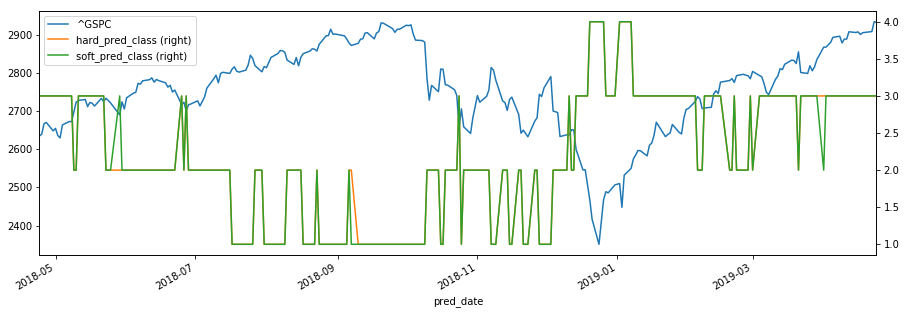

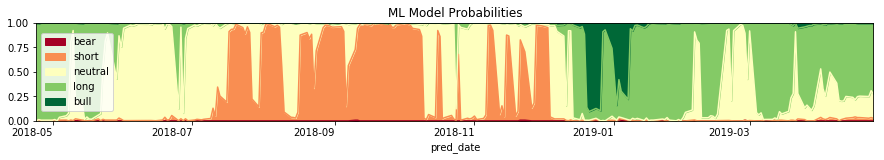

In [8]:
# Visualize macro predictions
pred_df = macro_df
pre_class_cols = filter_cols(pred_df.columns, "pred_class")
pred_df.loc[:,[bench] + pre_class_cols].plot(
    secondary_y=pre_class_cols, 
    figsize=(15, 5));
plt.savefig('../images/macro_chart.png', dpi=300, rot=0)
pred_df[fwd_ret_labels].plot.area(
        title='ML Model Probabilities',
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0);
f'Confidence Mean: {pred_df["soft_confidence"].mean().round(3)}, \
    Median {pred_df["soft_confidence"].median().round(3)}'
plt.savefig('../images/macro_prob.png', dpi=300)

### Bottom-up MLs

In [9]:
#
key_list = ['px_mom', 'fin_data', 'key_statistics', 'eps_trend', 'eps_estimates', 'day_quote']
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)

# Model score weights 
ml_score_dict = {
    'px_mom': 0.76, 'fin_data': 0.67, 'key_statistics': 0.71, 
    'eps_trend': 0.65, 'eps_estimates': 0.64, 'day_quote': 0.66, 
    'intrinsic_val': 0.7
}
cut_off_confidence = 0.6
model_scores = np.array(list(map(ml_score_dict.get, list(key_list))))
adj_weights = (model_scores - cut_off_confidence) / (model_scores - cut_off_confidence).sum()
model_weights = pd.Series({x:y for x,y in zip(list(key_list), adj_weights)})
model_weights

Loading files for 2019-04-24
PX_MOM, 1062 unique symbols
FIN_DATA, 1042 unique symbols
KEY_STATISTICS, 1065 unique symbols
EPS_TREND, 1089 unique symbols
EPS_ESTIMATES, 1089 unique symbols
DAY_QUOTE, 1102 unique symbols


px_mom           0.33
fin_data         0.14
key_statistics   0.22
eps_trend        0.10
eps_estimates    0.08
day_quote        0.12
dtype: float64

### Recomendations

#### Rolling days recommendation

In [10]:
# retrieve historical recommendations for the last 5 days
roll_pred_days = 10
super_list = []
for d in dates[:-roll_pred_days:-1]:
    lf_df = load_s3_preds(s3_path, d, key_list, eqty_symbols, verbose=False)
    wtg_df = get_wtd_ML_results(lf_df, model_weights)
    super_list.append(wtg_df)
hist_pred_df = pd.concat(super_list, axis=0)

print(f'Columns: {hist_pred_df.reset_index().columns}')
val_cols = ['wtg_class', 'wtg_ML_prob']
# remove duplicates required, given predictions on holidays
pvt_df = hist_pred_df.reset_index().drop_duplicates(subset=['symbol', 'pred_date'])\
    .pivot(index='symbol', columns='pred_date', values=val_cols)
# pvt_df = pvt_df.loc[(pvt_df.loc[pvt_df.index, 'wtg_ML_prob'] > min_confidence).all(axis=1), :]

hist_pred = pd.concat([
    pvt_df[val_cols[0]].mean(axis=1), 
    pvt_df[val_cols[1]].mean(axis=1)], axis=1)
hist_pred.columns = val_cols

Loading files for 2019-04-24
Loading files for 2019-04-23
Loading files for 2019-04-22
Loading files for 2019-04-19
Loading files for 2019-04-18
Loading files for 2019-04-17
Loading files for 2019-04-16
Loading files for 2019-04-15
Loading files for 2019-04-12
Columns: Index(['symbol', 'wtg_class', 'wtg_ML_prob', 'pred_date'], dtype='object')


In [15]:
show = ['wtg_class', 'wtg_ML_prob', 'conf_slope', 'forwardPE', 'shortName', 'sector', 'targetMedianPrice', 'size']

# best longs
L_df = hist_pred.loc[(hist_pred['wtg_class'] > 3) & (hist_pred['wtg_ML_prob'] > min_confidence), :]\
    .sort_values('wtg_ML_prob', ascending=False).head(max_rows)

L_df.loc[:, 'conf_slope'] = pvt_df.loc[L_df.index, 'wtg_ML_prob'].T.apply(conf_slope)
L_df = add_desc_stats(L_df, descriptive_cols)

# best shorts
S_df = hist_pred.loc[(hist_pred['wtg_class'] < 1) & (hist_pred['wtg_ML_prob'] > 0.3), :]\
    .sort_values('wtg_ML_prob', ascending=False).head(max_rows)

S_df.loc[:, 'conf_slope'] = pvt_df.loc[S_df.index, 'wtg_ML_prob'].T.apply(conf_slope)
S_df = add_desc_stats(S_df, descriptive_cols)

In [16]:
L_df[show].sort_values(by=['wtg_ML_prob'], ascending=False)

,wtg_class,wtg_ML_prob,conf_slope,forwardPE,shortName,sector,targetMedianPrice,size
symbol,,,,,,,,
VIPS,3.27,0.66,-0.01,10.37,Vipshop Holdings Limited,Consumer Cyclical,0.86,mid
BHP,3.08,0.58,0.01,26.13,BHP Group Limited,Basic Materials,0.87,large
VRSK,3.02,0.56,-0.01,28.42,"Verisk Analytics, Inc.",Industrials,0.94,large
TAL,3.07,0.56,-0.00,49.89,TAL Education Group,Consumer Defensive,1.05,large
AGN,3.10,0.55,0.02,8.05,Allergan plc,Healthcare,1.28,large
FLT,3.01,0.55,0.01,19.19,"FleetCor Technologies, Inc.",Industrials,1.01,large
BAX,3.04,0.55,-0.01,20.57,Baxter International Inc.,Healthcare,1.06,large
ECL,3.04,0.53,0.00,27.79,Ecolab Inc.,Basic Materials,0.93,large
RYN,3.14,0.52,-0.00,50.34,Rayonier Inc. REIT,Basic Materials,0.99,mid


In [17]:
S_df[show].sort_values(by='wtg_ML_prob', ascending=False)

,wtg_class,wtg_ML_prob,conf_slope,forwardPE,shortName,sector,targetMedianPrice,size
symbol,,,,,,,,
WH,0.91,0.36,-0.00,14.92,"Wyndham Hotels & Resorts, Inc.",Consumer Cyclical,1.26,mid
TREX,0.79,0.35,-0.01,26.38,"Trex Company, Inc.",Basic Materials,1.04,mid
ESL,0.85,0.33,0.01,23.92,Esterline Technologies Corporat,NaN,1.00,mid


In [18]:
# calculate # of shares
capital_alloc = 630000
roll_vol_window = 90
perf_window = 90

pos_list = excl(list(L_df.index), [])

indexed_perf_df = get_ind_index(px_close.loc[:, pos_list], tail=perf_window)
rank = L_df[['wtg_class','wtg_ML_prob']].rank(method='dense').sum(1).sort_values(ascending=False)

roll_vol_df = roll_vol(px_close[pos_list + ['^GSPC']].pct_change(), roll_vol_window)
vol_adj = 1 / (roll_vol_df.iloc[-1]/ roll_vol_df['^GSPC'].iloc[-1])

# volatility adjusted position sizing
# pos_sizes = (vol_adj.loc[pos_list] / vol_adj.loc[pos_list].sum()).sort_values()

# class and confidence ranking
pos_sizes = rank / rank.sum()

col_mapper = {
    'position_size': round(pos_sizes * 100, 1),
    'dollar_values': round(pos_sizes * capital_alloc),
    'share_count': round(pos_sizes * capital_alloc / quotes.loc[pos_list, 'regularMarketPrice'], 0),
    f'{roll_vol_window}d_vol': round(roll_vol_df.iloc[-1] * 100, 1),
    f'{perf_window}d_perf': round((indexed_perf_df.iloc[-1] - 1) * 100, 1)
}

col_mapper.update(L_df[['wtg_class','wtg_ML_prob','conf_slope']].to_dict())
long_snapshot = pd.DataFrame(col_mapper)

print(f'Weighted portfolio vol: {round(pos_sizes @ long_snapshot.loc[pos_sizes.index, "90d_vol"], 1)}')
long_snapshot.sort_values(by='position_size', ascending=False, inplace=True)
# csv_store(long_snapshot.reset_index(), 'recommend/portfolio/', f'long-{tgt_date}.csv')
long_snapshot

Weighted portfolio vol: 30.0


,position_size,dollar_values,share_count,90d_vol,90d_perf,wtg_class,wtg_ML_prob,conf_slope
VIPS,9.30,"58,500.00","7,231.00",59.90,43.80,3.27,0.66,-0.01
BHP,7.40,"46,500.00",872.00,25.10,11.80,3.08,0.58,0.01
AGN,6.90,"43,500.00",310.00,32.00,-7.10,3.10,0.55,0.02
CLB,6.90,"43,500.00",590.00,36.60,5.00,3.40,0.52,-0.00
RYN,6.70,"42,000.00","1,304.00",21.10,5.80,3.14,0.52,-0.00
TAL,6.20,"39,000.00","1,133.00",36.90,27.20,3.07,0.56,-0.00
GPN,6.20,"39,000.00",272.00,23.40,37.90,3.20,0.51,0.01
HALO,6.00,"37,500.00","2,306.00",39.40,6.40,3.13,0.52,0.01
VRSK,5.50,"34,500.00",247.00,18.00,21.10,3.02,0.56,-0.01
BAX,5.20,"33,000.00",430.00,20.20,14.70,3.04,0.55,-0.01


#### Daily recommendations

In [19]:
lf_df = load_s3_preds(s3_path, tgt_date, key_list, eqty_symbols)
wtg_df = get_wtd_ML_results(lf_df, model_weights)
wtg_df = add_desc_stats(wtg_df, descriptive_cols)

Loading files for 2019-04-23
PX_MOM, 1065 unique symbols
FIN_DATA, 1043 unique symbols
KEY_STATISTICS, 1067 unique symbols
EPS_TREND, 1091 unique symbols
EPS_ESTIMATES, 1091 unique symbols
DAY_QUOTE, 1104 unique symbols


In [20]:
# todays long positions
show = ['wtg_class','wtg_ML_prob','forwardPE', 'industry', 'targetMedianPrice', 'size']
L_df = wtg_df.loc[wtg_df['wtg_class'] > 3].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Long recommendations for {tgt_date}')
L_df.index

Long recommendations for 2019-04-23


Index(['AGN', 'VIPS', 'FICO', 'GOLD', 'EL', 'FLT', 'BHP', 'AMGN', 'STX', 'ZBH',
       'APD', 'DDS', 'ADI', 'VZ', 'OLED', 'RYN', 'NTDOY', 'POST', 'HAE',
       'SYMC'],
      dtype='object', name='symbol')

In [23]:
# todays short positions
S_df = wtg_df.loc[wtg_df['wtg_class'] < 1].sort_values(by='wtg_ML_prob', ascending=False).head(max_rows)
print(f'Short recommendations for {tgt_date}')
S_df.index

Short recommendations for 2019-04-23


Index(['GRUB', 'KT', 'GWPH', 'EXPE', 'SKT', 'FULT', 'PB', 'HBAN', 'CW', 'IPG',
       'PBCT', 'OSK', 'TXT', 'BMY', 'WH', '1810.HK', 'KMT', 'LYFT', 'ALK',
       'NVT'],
      dtype='object', name='symbol')

#### Company details

In [65]:
ticker = 'TSLA'
show = [
    'hard_pred_label','soft_pred_label','soft_confidence',
    'bear', 'short', 'neutral', 'long', 'bull', 'model']
wgt_input = (ticker, 'soft_confidence')
f'{quotes.loc[ticker].shortName}, {profile.loc[ticker].sector}, {profile.loc[ticker].industry}'

'Tesla, Inc., Consumer Cyclical, Auto Manufacturers'

In [66]:
# Company view across models
print(f'Model predictions for {ticker} on {tgt_date}')
print(f'Weighted ML confidence level: {score_wgt_conf(wgt_input)}')
lf_df.loc[lf_df['symbol'] == ticker, show]

Model predictions for TSLA on 2019-04-22
Weighted ML confidence level: 0.37099567131861505


,hard_pred_label,soft_pred_label,soft_confidence,bear,short,neutral,long,bull,model
pred_date,,,,,,,,,
2019-04-10,bull,bull,0.43,0.07,0.15,0.08,0.27,0.43,px_mom
2019-04-09,long,short,0.30,0.22,0.30,0.20,0.26,0.01,fin_data
2019-04-10,bear,short,0.40,0.32,0.40,0.09,0.16,0.03,key_statistics
2019-04-10,long,long,0.27,0.10,0.27,0.12,0.27,0.24,eps_trend
2019-04-10,neutral,long,0.26,0.21,0.19,0.12,0.26,0.22,eps_estimates
2019-04-10,bull,bull,0.39,0.12,0.16,0.11,0.23,0.39,day_quote


In [ ]:
quotes.loc[ticker]

### Universe Intrinsic Value Analysis

In [43]:
# Value companies in the universe
iv_show = ['premDisc', 'forwardPE', 'targetMedianPrice', 'pegRatio', 'growthRate']
iv_sizes = ['mega', 'large', 'mid']

iv_mask = (val_df.premDisc < 0.95) & (val_df.premDisc > 0)
iv_mapper = val_df.loc[iv_mask, 'premDisc']
iv_df = add_desc_stats(iv_mapper.to_frame(), descriptive_cols)
iv_df = iv_df.loc[iv_df['size'].isin(iv_sizes) & (iv_df.targetMedianPrice > 1.1), :]

iv_df.groupby(by=['sector', ]).agg(['count', 'median'])\
    .sort_values(by=(iv_show[0], 'median'))[iv_show]

premDisc        forwardPE         targetMedianPrice  \
                          count median     count  median             count   
sector                                                                       
Financial Services           26  0.341        26   9.827                26   
Industrials                   9  0.528         9   8.079                 9   
Basic Materials               5  0.633         5   7.105                 5   
Communication Services        3  0.661         2   5.612                 3   
Technology                    6  0.692         6  15.393                 6   
Consumer Defensive            2  0.745         2  14.130                 2   
Consumer Cyclical            14  0.763        14  10.911                14   
Healthcare                    8  0.768         8   9.531                 8   
Energy                       10  0.779         9   9.821                10   
Utilities                     2  0.803         2   3.990                 2   

                                pegRatio        growthRate         
                         median    count median      count median  
sector                                                             
Financial Services        1.130       26  0.827         26  0.116  
Industrials               1.152        9  1.100          9  0.073  
Basic Materials           1.254        5  1.004          5  0.070  
Communication Services    1.176        2    inf          3  0.027  
Technology                1.166        6  0.711          6  0.220  
Consumer Defensive        1.117        2  1.377          2  0.109  
Consumer Cyclical         1.161       14  1.608         14  0.059  
Healthcare                1.382        8  0.494          8  0.233  
Energy                    1.226        9  1.504         10  0.070  
Utilities               381.896        2    inf          2  0.039

In [44]:
iv_df.loc[:, iv_show + ['sector', 'size']].sort_values(
    by=['size', 'premDisc', 'sector'], ascending=False).head(max_rows)

,premDisc,forwardPE,targetMedianPrice,pegRatio,growthRate,sector,size
symbol,,,,,,,
FB,0.770,20.122,1.122,0.455,0.442,Technology,mega
BMY,0.941,10.252,1.252,0.393,0.261,Healthcare,large
PANW,0.941,36.619,1.210,1.864,0.196,Technology,large
HUM,0.926,12.523,1.460,0.609,0.206,Healthcare,large
TOT,0.887,8.990,1.252,1.504,0.060,Energy,large
REPYY,0.880,NaN,2.216,NaN,0.000,Energy,large
MCK,0.871,8.058,1.183,inf,0.000,Healthcare,large
COP,0.863,14.677,1.184,inf,0.000,Energy,large
GILD,0.842,9.084,1.303,inf,0.000,Healthcare,large


### Visualizations

model,px_mom,fin_data,key_statistics,eps_trend,eps_estimates,day_quote
soft_pred_label,,,,,,
bear,0.07,0.02,0.01,0.02,0.02,0.03
short,0.19,0.24,0.19,0.22,0.23,0.20
neutral,0.04,0.27,0.26,0.21,0.24,0.18
long,0.25,0.43,0.51,0.53,0.48,0.55
bull,0.46,0.03,0.03,0.02,0.03,0.05


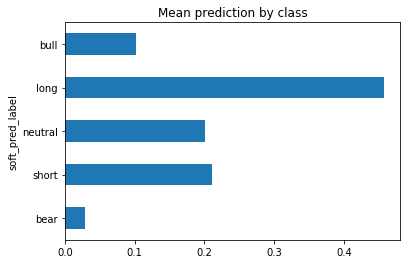

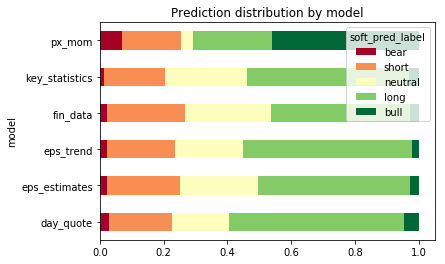

In [24]:
visualize_MLs(lf_df, key_list)

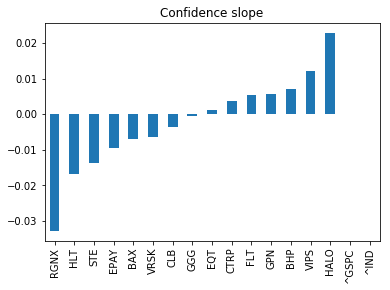

In [25]:
long_snapshot.conf_slope.sort_values().plot(kind='bar', title='Confidence slope');

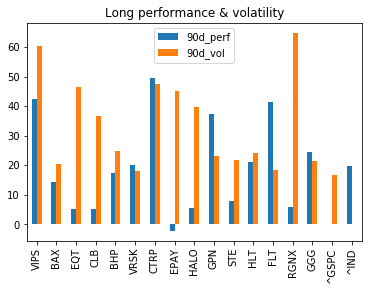

In [26]:
# 3 month indexed performance
long_snapshot.loc[
    long_snapshot.position_size.sort_values(ascending=False).index, 
    [f'{perf_window}d_perf', f'{roll_vol_window}d_vol']]\
    .plot(kind='bar', title='Long performance & volatility');

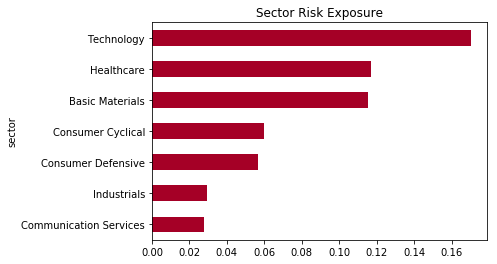

In [27]:
total_conf = pd.concat([L_df, S_df], axis=0, sort=False).wtg_ML_prob.sum()
long_sect_grps = L_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf
if len(S_df): long_sect_grps.append((S_df.groupby(by='sector').sum()['wtg_ML_prob'] / total_conf) * -1)
long_sect_grps = long_sect_grps.sort_values()
long_sect_grps.plot.barh(title='Sector Risk Exposure', cmap="RdYlGn")

plt.savefig('../images/ls_sector_exp.png', dpi=300, rot=0, bbox_inches='tight')

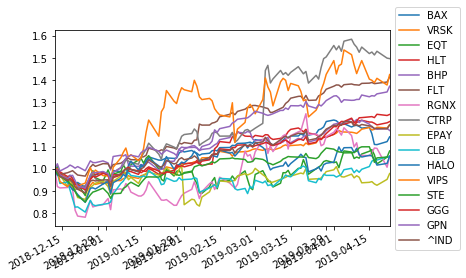

In [28]:
# backward looking performance of Long recommendations
indexed_perf_df.plot().legend(loc='center left', bbox_to_anchor=(1.0, 0.5));